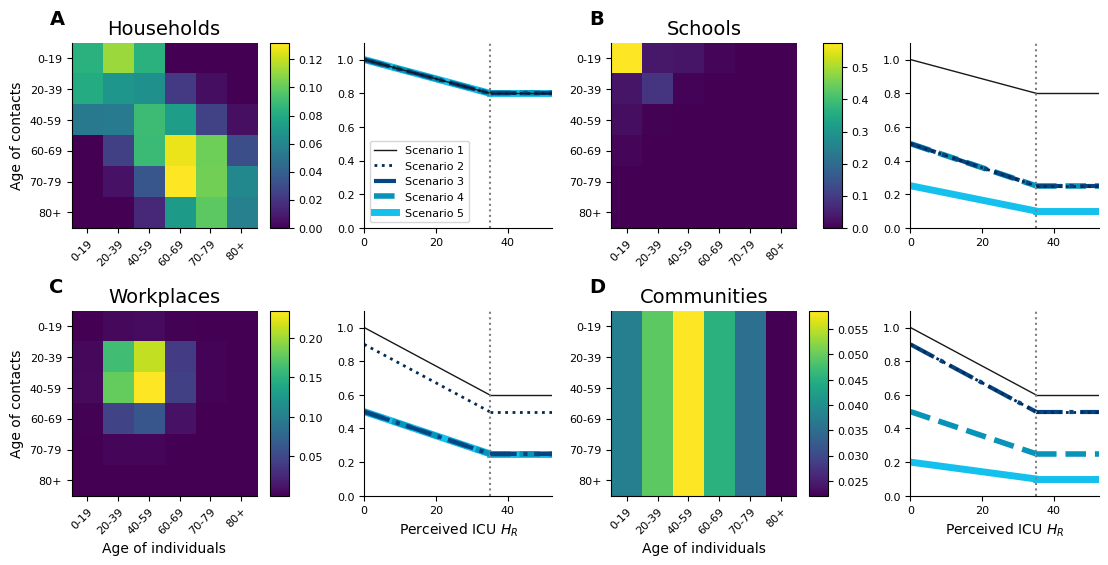

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("../code")
import plotting

plotting.set_rcParams(arial=False)

agegroups = ["0-19", "20-39", "40-59", "60-69","70-79", "80+"]
scenarios = ['Scenario 1', 'Scenario 2','Scenario 3','Scenario 4','Scenario 5']

C_household = np.loadtxt('../parameters/Germany_country_level_F_household_setting_85.csv', delimiter=',')
C_school = np.loadtxt('../parameters/Germany_country_level_F_school_setting_85.csv', delimiter=',')
C_workplace = np.loadtxt('../parameters/Germany_country_level_F_work_setting_85.csv', delimiter=',')
C_community = np.loadtxt('../parameters/Germany_country_level_F_community_setting_85.csv', delimiter=',')

germany = np.loadtxt('../parameters/germany.csv', delimiter=',')
germany[84,1]= germany[84:,1].sum()
germany = germany[:85,1]

w_h = 4.1100
w_s = 11.4100
w_w = 8.0700
w_c = 2.7900

ind = [0, 20, 40, 60, 70, 80, -1];

for i in range(85):
    for j in range(85):
        C_household[i,j] *= germany[i]*germany[j]
        C_school[i,j] *= germany[i]*germany[j]
        C_workplace[i,j] *= germany[i]*germany[j]
        C_community[i,j] *= germany[i]*germany[j]

C_H = np.zeros([6,6])
C_S = np.zeros([6,6])
C_W = np.zeros([6,6])
C_C = np.zeros([6,6])

def M(i):
    return germany[ind[i]:ind[i+1]].sum()
    

for i in range(6):
    for j in range(6):
        C_H[i,j] = C_household[ind[i]:ind[i+1],ind[j]:ind[j+1]].sum()/M(i)/M(j)
        C_S[i,j] = C_school[ind[i]:ind[i+1],ind[j]:ind[j+1]].sum()/M(i)/M(j)
        C_W[i,j] = C_workplace[ind[i]:ind[i+1],ind[j]:ind[j+1]].sum()/M(i)/M(j)
        C_C[i,j] = C_community[ind[i]:ind[i+1],ind[j]:ind[j+1]].sum()/M(i)/M(j)

C = w_h*C_H + w_s*C_S + w_w*C_W + w_c*C_C
rho = max(np.linalg.eigvals(C))

C_H = w_h * C_H / rho
C_S = w_s * C_S / rho
C_W = w_w * C_W / rho
C_C = w_c * C_C / rho

data = pd.read_csv('../parameters/scenariosDefinition.csv', sep=';', header=0)


fig = plt.figure(figsize=(4*2.75,2*2.75), constrained_layout=True)
grid = fig.add_gridspec(ncols=4, nrows=2, hspace=0.2, wspace=0.15)
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])
ax4 = fig.add_subplot(grid[3])
ax5 = fig.add_subplot(grid[4])
ax6 = fig.add_subplot(grid[5])
ax7 = fig.add_subplot(grid[6])
ax8 = fig.add_subplot(grid[7])

matrixaxes = [ax1,ax3,ax5,ax7]
scenarioaxes = [ax2,ax4,ax6,ax8]

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.titlesize"]= 14


#[C_household, C_school, C_workplace, C_community]
#[C_H, C_S, C_W, C_C]
for ax, matrix in zip(matrixaxes, [C_H, C_S, C_W, C_C]):
    ax.imshow(matrix)
    ax.figure.colorbar(ax.imshow(matrix), ax=ax, cmap="YlGn")


#Matrix labels:
labels=['Households','Schools','Workplaces','Communities']

for ax in matrixaxes:
    ax.set_xticks(np.arange(len(agegroups)))
    ax.set_yticks(np.arange(len(agegroups)))
    ax.set_xticklabels(agegroups)
    #ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(agegroups)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    
    if ax==ax1 or ax == ax5:
        ax.set_ylabel('Age of contacts')
    if ax==ax5 or ax == ax7:
        ax.set_xlabel('Age of individuals')
        
for ax, label,t in zip(matrixaxes, ['A','B','C','D'],labels):
        ax.text(-.12,1.1,label, size=14, weight='bold', color='black', transform=ax.transAxes)
        ax.set_title(t)


Hmax = 35

highvalues = ['householdlow','schoollow','workplacelow','communitylow']
lowvalues = ['householdhigh','schoolhigh','workplacehigh','communityhigh']

hline1 = np.linspace(0,Hmax,100)
hline2 = np.linspace(Hmax,1.5*Hmax,100)


colors = ['#19191b','#022b53','#054583','#0894b8', '#14c1ed']


linestyles=['-',':','-.','--','-']
linewidths = [2,2.5,3,3.5,4]
linewidths = [1,2,3,4,5]
order = [-1,-2,-3,-4,-5]

for ax, highs, lows in zip(scenarioaxes, highvalues, lowvalues):
    ax.set_ylim(0,1.1)
    ax.set_xlim(0,Hmax*1.5)
    if ax== ax6 or ax==ax8:
        ax.set_xlabel('Perceived ICU $H_R$')
    ax.axvline(Hmax,linestyle=':',color='gray')
    for i, o, c, l1, l2, scen in zip([0,1,2,3,4],order, colors,linestyles,linewidths,scenarios):
        ax.plot(hline1, (data[lows][i]-(data[lows][i]-data[highs][i])/Hmax*hline1), color=c, lw=l2, ls=l1,zorder=o)
        ax.plot(hline2, (data[highs][i]*np.ones(len(hline2))), color=c, lw=l2, ls=l1,zorder=o, label=scen)
        
ax2.legend()
    


plt.savefig('./figures/matrices_reduction.pdf')
plt.show()